In [161]:
import pandas as pd
import numpy as np
import copy
import random
from math import sqrt
import scipy.stats as sts

from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [162]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [163]:
from supplement_package.game.gradient import GradientComputation
from supplement_package.game.player import Player
from supplement_package.game.stackelberg import StackelbergPlayer
from supplement_package.game.stackelberg import StackelbergGradientComputation

In [164]:
from supplement_package.variables_pecan.variables import VariablesStorage
from supplement_package.variables_pecan.variables import VariablesGenerator

## Data preliminaries 

In [165]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

In [166]:
community_size = len(dataframe_dict)

D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]
#Kappa = [[0 for i in range(community_size)] for i in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]

probabilities = np.array([0.333, 0.333, 0.333])
#probabilities = np.array([0.25 for i in range(4)])

#Building connections between the nodes

connection_matrix = [[np.random.choice([0,1], p = [0.7,0.3]) for i in range(community_size)] for i in range(community_size)]

for i in range(community_size):
    for j in range(community_size):
        connection_matrix[j][i] = connection_matrix[i][j] if i!=j else 0


Gamma = np.array([0.33, 0.33, 0.33])


len_probas = len(probabilities)


In [171]:
def generate_new_params(sample_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,1) for i in range(community_size)]
        B_tilde = [random.uniform(0,1) for i in range(community_size)]

        a = [random.uniform(0,1) for i in range(community_size)]
        b = [random.uniform(0,1) for i in range(community_size)]
        d = [random.uniform(0,1) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv('../data/param_10k.csv')

In [172]:
#generate_new_params(10000)

In [173]:
df_param = pd.read_csv('../data/param_10k.csv')
df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
df_param.set_index(['Sample', 'Parameter'], inplace=True)

In [174]:
df_param

0         1         2         3         4  \
Sample Parameter                                                         
0      A_tilde        0.217812  0.279961  0.667903  0.143819  0.125303   
       B_tilde        0.899213  0.081175  0.819147  0.900771  0.655831   
       a              0.492533  0.604852  0.518921  0.824407  0.800550   
       b              0.714653  0.236258  0.404666  0.218374  0.974118   
       d              0.249116  0.637582  0.959250  0.208308  0.931836   
...                        ...       ...       ...       ...       ...   
9999   B_tilde        0.914918  0.911905  0.770397  0.602768  0.092085   
       a              0.021521  0.738979  0.625050  0.915818  0.388559   
       b              0.892882  0.414944  0.467618  0.768742  0.506947   
       d              0.329563  0.271076  0.781528  0.445178  0.551710   
       risk_aversion  0.038079  0.141557  0.451150  0.938095  0.791038   

                             5         6         7         8         9  ...  \
Sample Parameter                                                        ...   
0      A_tilde        0.158717  0.619077  0.859816  0.529881  0.304539  ...   
       B_tilde        0.942734  0.580991  0.201260  0.393880  0.785217  ...   
       a              0.395307  0.630867  0.839850  0.746278  0.338406  ...   
       b              0.458508  0.384214  0.155242  0.507262  0.096454  ...   
       d              0.284484  0.968097  0.256652  0.402486  0.756583  ...   
...                        ...       ...       ...       ...       ...  ...   
9999   B_tilde        0.211341  0.843491  0.187897  0.470073  0.723902  ...   
       a              0.132593  0.378492  0.017968  0.111353  0.387130  ...   
       b              0.006410  0.937495  0.558386  0.589288  0.389694  ...   
       d              0.757793  0.776919  0.882744  0.969449  0.765972  ...   
       risk_aversion  0.636816  0.215019  0.758958  0.466554  0.616560  ...   

                            15        16        17        18        19  \
Sample Parameter                                                         
0      A_tilde        0.980217  0.943197  0.131499  0.328368  0.849205   
       B_tilde        0.744526  0.188241  0.039306  0.451518  0.724917   
       a              0.081315  0.956845  0.299011  0.416244  0.644212   
       b              0.079701  0.449695  0.585233  0.634159  0.278377   
       d              0.115290  0.075716  0.771956  0.867613  0.519584   
...                        ...       ...       ...       ...       ...   
9999   B_tilde        0.932881  0.606272  0.801189  0.898732  0.041348   
       a              0.765844  0.448655  0.910923  0.055791  0.993781   
       b              0.821872  0.742031  0.545822  0.033992  0.900476   
       d              0.491596  0.791417  0.623705  0.867145  0.115491   
       risk_aversion  0.894521  0.450922  0.641666  0.943290  0.696052   

                            20        21        22        23        24  
Sample Parameter                                                        
0      A_tilde        0.111011  0.875752  0.547855  0.175584  0.492380  
       B_tilde        0.449303  0.140702  0.942274  0.797263  0.320961  
       a              0.553241  0.259481  0.581877  0.827786  0.013783  
       b              0.496750  0.638313  0.776575  0.732446  0.887163  
       d              0.229973  0.441528  0.620648  0.745656  0.825635  
...                        ...       ...       ...       ...       ...  
9999   B_tilde        0.585941  0.499628  0.873160  0.177425  0.762384  
       a              0.937999  0.807931  0.815794  0.539482  0.482822  
       b              0.672090  0.249831  0.193554  0.476643  0.788864  
       d              0.051631  0.121156  0.996148  0.720697  0.922051  
       risk_aversion  0.984684  0.025646  0.173325  0.821753  0.935958  

[60000 rows x 25 columns]

In [315]:
dataframe_dict[661]

,date,time,air1,bathroom1,car1,clotheswasher1,dishwasher1,disposal1,drye1,furnace1,grid,kitchenapp1,kitchenapp2,microwave1,refrigerator1,solar,demand,difference
0,2018-11-21,15:15:00,0.0,0.004,0.001,0.0,0.001,0.0,0.0,0.235,0.124,0.004,0.199,0.002,0.002,0.276,0.448,-0.048
1,2018-11-21,15:30:00,0.0,0.004,0.001,0.0,0.001,0.0,0.0,0.235,0.251,0.004,0.199,0.002,0.002,0.167,0.448,-0.030
2,2018-11-21,15:45:00,0.0,0.004,0.001,0.0,0.001,0.0,0.0,0.235,0.419,0.004,0.199,0.002,0.002,0.179,0.448,0.150
3,2018-11-21,16:00:00,0.0,0.004,0.007,0.0,0.001,0.0,0.0,0.235,0.833,0.004,0.199,0.002,0.002,0.076,0.454,0.455
4,2018-11-21,16:15:00,0.0,0.004,0.014,0.0,0.001,0.0,0.0,0.235,1.105,0.004,0.199,0.002,0.002,0.064,0.461,0.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35027,2018-12-31,22:45:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.024,1.497,0.004,0.182,0.006,0.029,-0.014,0.253,1.230
35028,2018-12-31,23:00:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.190,1.747,0.004,0.181,0.006,0.141,-0.014,0.530,1.203
35029,2018-12-31,23:15:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.010,1.440,0.004,0.182,0.006,0.065,-0.013,0.275,1.152
35030,2018-12-31,23:30:00,0.0,0.005,0.002,0.0,0.001,0.0,0.0,0.140,1.345,0.004,0.182,0.006,0.006,-0.012,0.346,0.987


<AxesSubplot:ylabel='Count'>

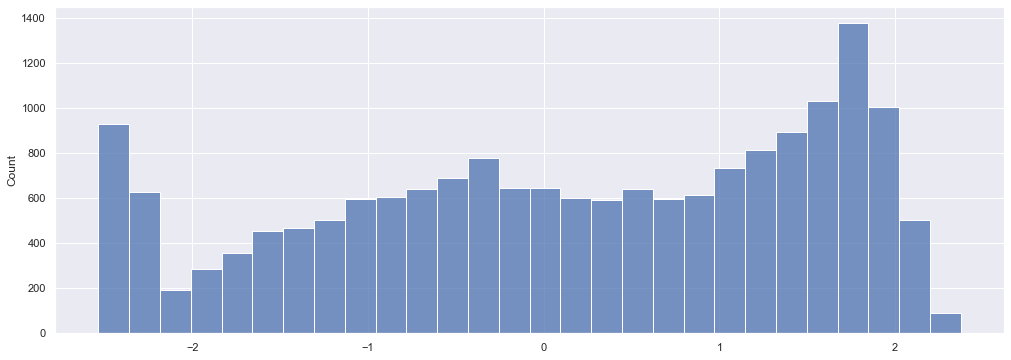

In [175]:
data, n_param = sts.boxcox((dataframe_dict[661][dataframe_dict[661]['solar'] > 0]['solar']))
# Create the plot grid
#fig = plt.figure(figsize=(18,6))
# Histogram
plt.figure(figsize = (17,6))
sns.histplot(data)

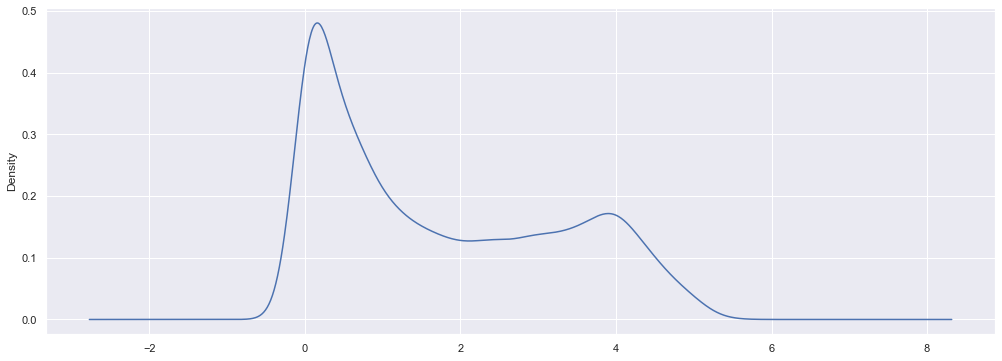

In [178]:
plt.figure(figsize = (17,6))
(dataframe_dict[661][dataframe_dict[661]['solar'] > 0]['solar']).plot.kde();

In [179]:
for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.001) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.999))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

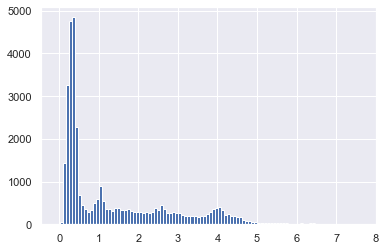

In [330]:
res = plt.hist(dataframe_dict[key]['demand'], bins = 100)

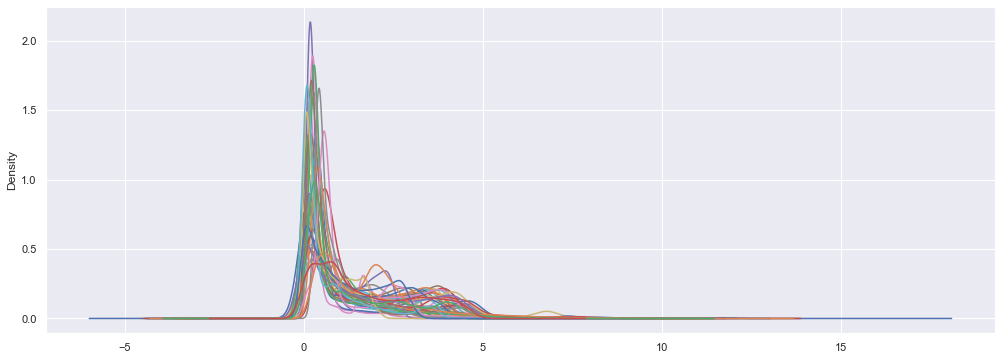

In [180]:
plt.figure(figsize = (17,6))
demand_dict = {}
solar_dict = {}
for key in agent_keys:
    density_demand = dataframe_dict[key]['demand'].plot.kde()

    if 'solar' in dataframe_dict[key].columns and dataframe_dict[key]['solar'].dropna().nunique() > 1:
        density_solar = (dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']).plot.kde()
        #density_solar = dataframe_dict[key]['solar'].plot.kde()

    density_demand_x = density_demand.get_children()[0]._x
    density_demand_y = density_demand.get_children()[0]._y

    density_solar_x = density_solar.get_children()[0]._x
    density_solar_y = density_solar.get_children()[0]._y

    demand_dict.update({key: (density_demand_x, density_demand_y)})
    solar_dict.update({key :(density_solar_x, density_solar_y)})

In [256]:
sample_size = 500

chunks_demand = int(demand_dict[661][0].size / sample_size)
chunks_generation = int(solar_dict[661][0].size / sample_size)


probas_demand = [np.trapz(demand_dict[661][1][i * chunks_demand : (i + 1) * chunks_demand],
                            demand_dict[661][0][i * chunks_demand : (i + 1) * chunks_demand])
                            for i in range(sample_size)]

values_demand = [demand_dict[661][0][i * chunks_demand : (i + 1) * chunks_demand].mean() for i in range(sample_size)]

In [259]:
pr = demand_dict[661][1]

In [264]:
pr = pr / np.sum(pr)

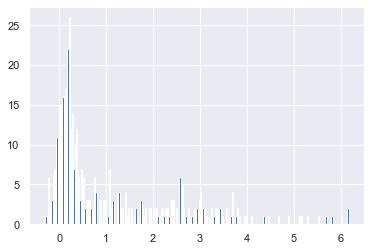

In [278]:
res_1 = plt.hist(np.random.choice(demand_dict[661][0], size = 500, p = pr), bins = 250)

In [279]:
res_1

(array([ 1.,  1.,  1.,  6.,  1.,  3.,  3.,  6.,  7.,  5., 11.,  9.,  5.,
        15., 12., 16., 13., 17., 17., 22., 26., 12.,  7., 14.,  7., 10.,
        12.,  7.,  6.,  3.,  7.,  5.,  6.,  2.,  3.,  3.,  1.,  3.,  2.,
         2.,  2.,  6.,  4.,  0.,  0.,  3.,  3.,  0.,  3.,  3.,  1.,  0.,
         1.,  7.,  2.,  1.,  3.,  0.,  0.,  0.,  4.,  4.,  2.,  1.,  2.,
         0.,  4.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,  1.,  2.,  1.,  0.,
         0.,  3.,  2.,  1.,  0.,  2.,  0.,  0.,  2.,  2.,  0.,  0.,  2.,
         2.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  2.,  0.,  2.,  1.,  0.,
         3.,  0.,  3.,  0.,  2.,  0.,  0.,  6.,  0.,  5.,  2.,  1.,  1.,
         1.,  2.,  1.,  0.,  1.,  0.,  2.,  2.,  2.,  2.,  3.,  4.,  2.,
         2.,  2.,  1.,  1.,  0.,  1.,  1.,  2.,  0.,  1.,  2.,  2.,  0.,
         2.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  1.,  4.,  0.,
         0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [347]:
def distribution_build(sample_size, agent_keys):
    res = {}
    probabilities = demand_dict[661][1] / demand_dict[661][1].sum()
    for key in agent_keys:
        #chunks_demand = int(demand_dict[key][0].size / sample_size)
        #chunks_generation = int(solar_dict[key][0].size / sample_size)


        #probas_demand = [np.trapz(demand_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            demand_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_demand)]

        #probas_generation = [np.trapz(generation_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            generation_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_generation)]

        #res_demand = plt.hist(np.random.choice(demand_dict[key][0], size = sample_size, p = probabilities), bins = int(sample_size / 2))
        #probas_update = res_demand[0] / res_demand[0].sum() if key == 661 else res[661]['probabilities']
        #res.update({key : 
        #            {'values' : res_demand[1], 
        #            'probabilities' : probas_update}})

        hist_demand = plt.hist(dataframe_dict[key]['demand'], bins = sample_size)
        probas_demand, values_demand = hist_demand[0], hist_demand[1]
        probas_demand = probas_demand / probas_demand.sum()

        if 'solar' in dataframe_dict[key].columns:
            hist_solar = plt.hist(dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar'], bins = sample_size)
            probas_solar , values_solar  = hist_solar[0], hist_solar[1]
            probas_solar = probas_demand / probas_demand.sum()

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar}})

    return res 


In [351]:
def scenario_sampling(sample_size, agent_keys, main_key = 661):
    distribution = distribution_build(sample_size, agent_keys)

    probabilities = distribution[main_key]['probas_demand']

    d_target = []
    g_res = []
    for key in agent_keys:
        d_target.append(distribution[key]['values_demand'])
        g_res.append(distribution[key]['values_solar'])

    return probabilities, d_target, g_res

In [ ]:
def param_input(df):
    A_tilde = list(df.loc[0].loc['A_tilde'])
    B_tilde = list(df.loc[0].loc['B_tilde'])
    a = list(df.loc[0].loc['a'])
    b = list(df.loc[0].loc['b'])
    d = list(df.loc[0].loc['d'])
    risk_aversion = list(df.loc[0].loc['risk_aversion'])

    return A_tilde, B_tilde, a, b, d, risk_aversion


In [ ]:
probabilities, d_target, g_res = scenario_sampling(500, agent_keys)
A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param)

In [8]:
agents = []
StackelbergPlayer.community_size = community_size
StackelbergPlayer.probabilities = probabilities

epsilon = 0.001
alpha = [[proba/(1 - risk_aversion[i]) - epsilon for proba in probabilities] for i in range(community_size)]
#alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

j_max = [10 for i in range(community_size)]

for i in range(community_size):
    agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                alpha = alpha[i], 
                gamma = gamma, 
                insurance_bound=10)
    
    agents.append(agent)

## Gurobi

In [13]:
import gurobipy as gp

In [15]:
def gurobi_model(agents, model, alpha, gamma):
    qExpr_G = gp.QuadExpr()
    qExpr_D = gp.QuadExpr()
    lExpr_q = gp.LinExpr()
    lExpr_W = gp.LinExpr()
    lExpr_J = gp.LinExpr()
    lExpr_u = gp.LinExpr()
    lExpr_obj = gp.LinExpr()

    for agent in agents:
        eta = model.addVar(lb = - float('inf'),
                        ub = float('inf'),
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'eta_{agent.id}')

        for proba in agent.probabilities_ind:
            G = model.addVar(lb = agent.G_min, 
                            ub = agent.G_max, 
                            vtype=gp.GRB.CONTINUOUS, 
                            name = f'G_{agent.id}_{proba}')

            qExpr_G.add(agent.a * G * G + agent.b * G + agent.d)

            D = model.addVar(lb = agent.D_min,
                            ub = agent.D_max,
                            vtype = gp.GRB.CONTINUOUS,
                            name = f'D_{agent.id}_{proba}')

            qExpr_D.add(agent.a_tilde * (D - agent.D_target[proba]) * (D - agent.D_target[proba]) + agent.b_tilde)

            W = model.addVar(lb = - float('inf'),
                        ub = float('inf'),
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'W_{agent.id}_{proba}')
        
            lExpr_W.add(W * gamma[proba])

            J = model.addVar(lb = 0.0,
                        ub = agent.j_max,
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'J_{agent.id}_{proba}')

            lExpr_J.add(J * alpha[agent.id][proba])

            sum_q = gp.LinExpr()
            for player in agents:
                q = (
                    model.addVar(lb = - agent.kappa[player.id],
                                ub = agent.kappa[player.id],
                                vtype = gp.GRB.CONTINUOUS,
                                name = f'q_{agent.id}_{player.id}_{proba}') if agent.connections[player.id] 
                    else 
                        model.addVar(lb = 0,
                                ub = 0,
                                vtype = gp.GRB.CONTINUOUS,
                                name = f'q_{agent.id}_{player.id}_{proba}')
                    )

                lExpr_q.add(agent.trading_cost[player.id] * q)
                sum_q.add(q)

            model.addConstr(D == G + agent.G_res[proba] + sum_q, 
                            name= f'SD balance for agent {agent.id} proba {proba}')

            u = model.addVar(lb = 0,
                            ub = float('inf'),
                            vtype = gp.GRB.CONTINUOUS,
                            name = f'u_{agent.id}_{proba}')

            lExpr_u.add(u * proba / (1 - agent.risk_aversion))

            lExpr_obj.add(lExpr_J + lExpr_W + lExpr_u)

            model.addConstr(qExpr_G + qExpr_D + lExpr_q - eta - u <= 0, 
                            name=f'Residual constraint for agent {agent.id} proba {proba}')

        lExpr_obj.add(eta)

    model.setObjective(lExpr_obj, gp.GRB.MINIMIZE)
    model.update()

        

In [16]:
def gurobi_bilateral_trading(agents, model):
    for agent in agents:
        for agent_2 in agents:
            if agent.connections[agent_2.id]:
                for proba in agent.probabilities_ind:

                    model.addConstr(model.getVarByName(f'q_{agent.id}_{agent_2.id}_{proba}')  
                                    + model.getVarByName(f'q_{agent_2.id}_{agent.id}_{proba}') == 0, 
                                    name = f'Bilateral trading for pair ({agent.id}, {agent_2.id}) proba {proba}')

    model.update()

In [17]:
model_1 = gp.Model()


[<gurobi.Var eta_0>,
 <gurobi.Var G_0_0>,
 <gurobi.Var D_0_0>,
 <gurobi.Var q_0_0_0>,
 <gurobi.Var q_0_1_0>,
 <gurobi.Var q_0_2_0>,
 <gurobi.Var q_0_3_0>,
 <gurobi.Var q_0_4_0>,
 <gurobi.Var q_0_5_0>,
 <gurobi.Var q_0_6_0>,
 <gurobi.Var q_0_7_0>,
 <gurobi.Var q_0_8_0>,
 <gurobi.Var q_0_9_0>,
 <gurobi.Var q_0_10_0>,
 <gurobi.Var q_0_11_0>,
 <gurobi.Var q_0_12_0>,
 <gurobi.Var q_0_13_0>,
 <gurobi.Var q_0_14_0>,
 <gurobi.Var q_0_15_0>,
 <gurobi.Var q_0_16_0>,
 <gurobi.Var q_0_17_0>,
 <gurobi.Var q_0_18_0>,
 <gurobi.Var q_0_19_0>,
 <gurobi.Var q_0_20_0>,
 <gurobi.Var q_0_21_0>,
 <gurobi.Var q_0_22_0>,
 <gurobi.Var q_0_23_0>,
 <gurobi.Var q_0_24_0>,
 <gurobi.Var u_0_0>,
 <gurobi.Var G_0_1>,
 <gurobi.Var D_0_1>,
 <gurobi.Var q_0_0_1>,
 <gurobi.Var q_0_1_1>,
 <gurobi.Var q_0_2_1>,
 <gurobi.Var q_0_3_1>,
 <gurobi.Var q_0_4_1>,
 <gurobi.Var q_0_5_1>,
 <gurobi.Var q_0_6_1>,
 <gurobi.Var q_0_7_1>,
 <gurobi.Var q_0_8_1>,
 <gurobi.Var q_0_9_1>,
 <gurobi.Var q_0_10_1>,
 <gurobi.Var q_0_11_1>,
 <guro

In [60]:
def gurobi_utility_generation(agent):
    qExpr = gp.QuadExpr()
    for proba in agent.probabilities_ind:
        G = model.addVar(lb = agent.G_min, 
                        ub = agent.G_max, 
                        vtype=gp.GRB.CONTINUOUS, 
                        name = f'G_{agent.id}_{proba}')
        qExpr.add(agent.a * G * G + agent.b * G + agent.d)
    
    return qExpr

In [66]:
def gurobi_utility_demand(agent):
    qExpr = gp.QuadExpr()
    for proba in agent.probabilities_ind:
        D = model.addVar(lb = agent.D_min,
                        ub = agent.D_max,
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'D_{agent.id}_{proba}')
        qExpr.add(agent.a_tilde * (D - agent.D_target[proba]) * (D - agent.D_target[proba]) + agent.b_tilde)

    return qExpr

In [111]:
def gurobi_trading_cost(agent, agents):
    lExpr = gp.LinExpr()

    for player in agents:
        for proba in agent.probabilities_ind:
            q = (
                model.addVar(lb = - agent.kappa[player.id],
                            ub = agent.kappa[player.id],
                            vtype = gp.GRB.CONTINUOUS,
                            name = f'q_{agent.id}_{player.id}_{proba}') if agent.connections[player.id] 
                else 
                    model.addVar(lb = 0,
                            ub = 0,
                            vtype = gp.GRB.CONTINUOUS,
                            name = f'q_{agent.id}_{player.id}_{proba}')
                )

            lExpr.add(agent.trading_cost[player.id] * q)
    
    return lExpr

In [110]:
def gurobi_contracts_in_utility(agent, gamma, alpha):
    lExpr = gp.LinExpr()

    for proba in agent.probabilities_ind:
        W = model.addVar(lb = - float('inf'),
                        ub = float('inf'),
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'W_{agent.id}_{proba}')
        
        lExpr.add(W * gamma[proba])

        J = model.addVar(lb = 0.0,
                        ub = agent.j_max,
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'J_{agent.id}_{proba}')

        lExpr.add(J * alpha[agent.id][proba])

    return lExpr

In [89]:
def gurobi_residuals_utility(agent):
    lExpr = gp.LinExpr()

    for ind, proba in enumerate(agent.probabilities):
        u = model.addVar(lb = 0,
                        ub = float('inf'),
                        vtype = gp.GRB.CONTINUOUS,
                        name = f'u_{agent.id}_{proba}')

        lExpr.add(u * proba / (1 - agent.risk_aversion))

    return lExpr

In [103]:
a,b, = gurobi_contracts_in_utility(agents[0], gamma, alpha)

In [113]:
gurobi_trading_cost(agents[0], agents)
model.update()

In [84]:
obj = (gp.quicksum((gurobi_utility_generation(agent) for agent in agents)) +
        gp.quicksum((gurobi_utility_demand(agent) for agent in agents)) +
        gp.quicksum((gurobi_trading_cost(agent, agents) for agent in agents)))
        
model.setObjective(obj, gp.GRB.MINIMIZE)

model.getObjective()

<gurobi.LinExpr: 0.0>

## Decentralized gradient descent

In [8]:
x_0 = np.zeros(len_probas + len_probas + 1 + len_probas + len_probas*community_size)
#D - 0 : len_probas
#G - len_probas : 2*len_probas 
#eta - 2*len_probas
#u - 2*len_probas + 1 : 3*len_probas +1
#q - 3*len_probas +1 :


In [9]:
agents[0].__dict__

{'id': 0,
 'D_target': [2.4732426664167235, 2.3171056718826026, 2.9109718140000096],
 'G_res': [1.9463173638152291, 1.5512193219328663, 1.3288704235974245],
 'a': 0.3527362838894421,
 'b': 0.681966804864529,
 'd': 0.22547321395357256,
 'a_tilde': 0.7532292489731499,
 'b_tilde': 0.8946315208907712,
 'D_min': 0,
 'D_max': 9.172999999999998,
 'G_min': 0,
 'G_max': 8.552,
 'risk_aversion': 0.7265233673462,
 'probabilities_ind': [0, 1, 2],
 'trading_cost': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'connections': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1],
 'kappa': array([ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10,  0,  0, 10,
         0,  0,  0,  0,  0, 10,  0, 10]),
 'G': array([0., 0., 0.]),
 'D': array([0., 0., 0.]),
 'eta': 0,
 'u': array([0., 0., 0.]),
 'q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0

In [10]:
mu = 0.03
rho = 2000
k = 0

plot_penalty_residual = [[[] for j in range(len(probabilities))] for i in range(community_size)]
plot_balance = [[[] for j in range(len(probabilities))] for i in range(community_size)]

min_ra = min(risk_aversion)
while k <= 10000:
    #print(k)
    #print('--------------------------')
    for agent in agents:
        #Update of grad_d of the agent

        agent.grad_D = rho*(StackelbergGradientComputation.penalty_dmin(agent) 
                            + StackelbergGradientComputation.penalty_dmax(agent)
                            + StackelbergGradientComputation.penalty_balance(agent)['update_d']
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_d'])

        agent.grad_G = rho*(StackelbergGradientComputation.penalty_gmin(agent) 
                            + StackelbergGradientComputation.penalty_gmax(agent)
                            + StackelbergGradientComputation.penalty_balance(agent)['update_g']
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_g'])

        agent.grad_eta = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_eta']
                        + rho*StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_eta'])

        agent.grad_u = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_u']
                        + rho*StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_u']
                        + rho*StackelbergGradientComputation.penalty_u(agent))



        agent.grad_q = rho*(StackelbergGradientComputation.penalty_trading_bound(agent)
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_q']
                            + StackelbergGradientComputation.penalty_balance(agent)['update_q']
                            + StackelbergGradientComputation.penalty_bilateral_trading(agent, agents))

        agent.grad_w = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_w']
                            + rho * StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_w']
                            + rho * StackelbergGradientComputation.penalty_risk_balance(agents))

        agent.grad_j = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_j']
                            + rho * StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_j']
                            + rho * StackelbergGradientComputation.penalty_jmin(agent)
                            + rho * StackelbergGradientComputation.penalty_jmax(agent))
        

        #print('Agent {} variables'.format(agent.id))
        #print(agent.variables_to_vector())
        #print('--------------------------------')

    #Agent's variables update
    for agent in agents:

        N = k+1000

        agent.D = agent.D - mu/(N)*agent.grad_D
        agent.G = agent.G - mu/(N)*agent.grad_G
        agent.eta = agent.eta - mu/(N) * agent.grad_eta
        agent.u = agent.u - mu/(N)*agent.grad_u
        agent.q = agent.q - mu/(N)*agent.grad_q
        agent.w = agent.w - mu/(N)*agent.grad_w
        agent.j = agent.j - mu/(N)*agent.grad_j

        agent.plot_eta.append(agent.eta)

        for i in range(len(probabilities)):
            agent.plot_d[i].append(agent.D[i])
            agent.plot_g[i].append(agent.G[i])
            agent.plot_u[i].append(agent.u[i])
            agent.plot_w[i].append(agent.w[i])
            agent.plot_j[i].append(agent.j[i])

            plot_penalty_residual[agent.id][i].append(StackelbergGradientComputation.stackelberg_penalty_residual(agent)['violation'])
            plot_balance[agent.id][i].append(StackelbergGradientComputation.penalty_balance(agent)['violation'])

            for agent_2 in agents:
                agent.plot_q[agent_2.id][i].append(agent.q[agent_2.id][i])
    
    

    k +=1

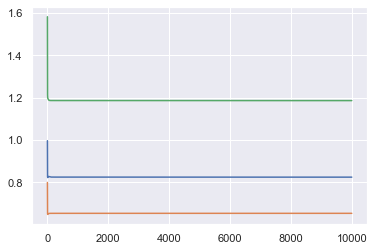

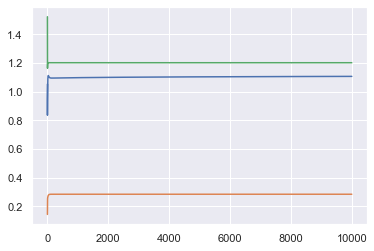

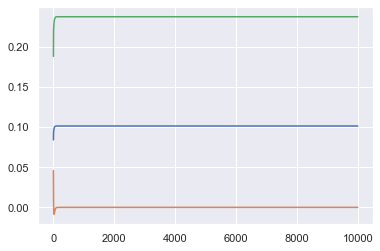

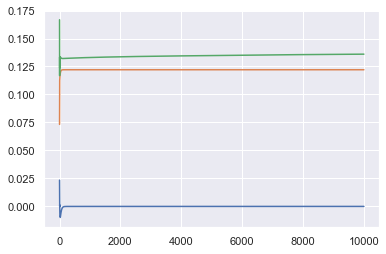

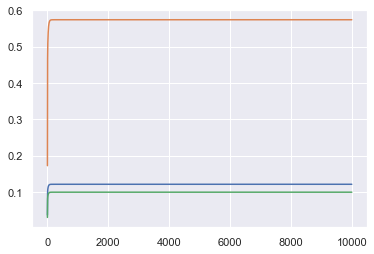

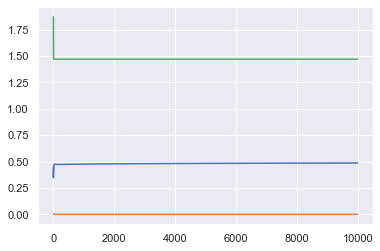

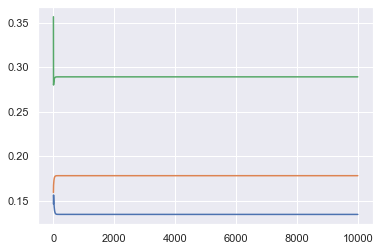

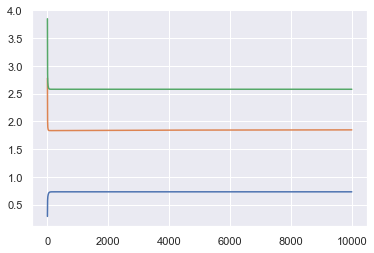

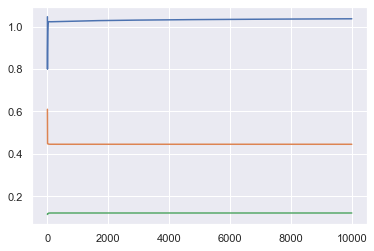

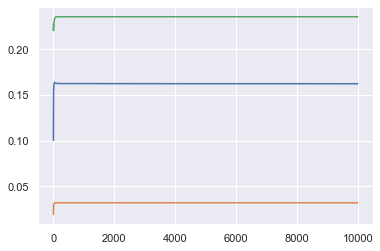

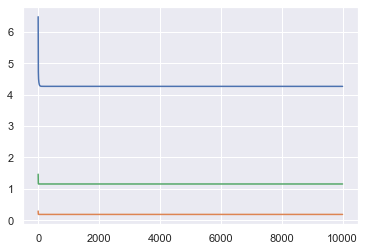

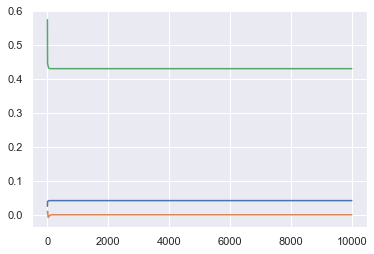

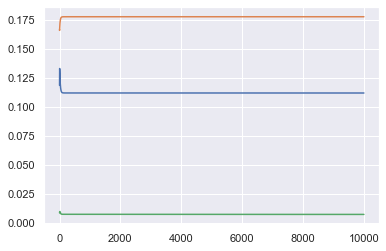

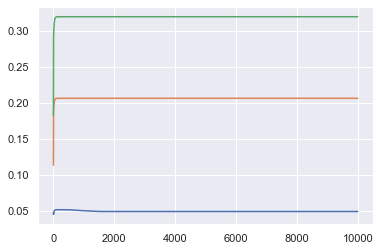

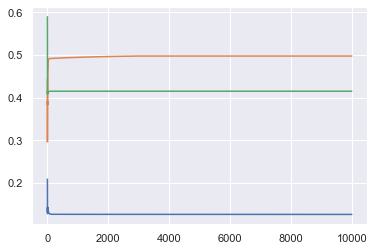

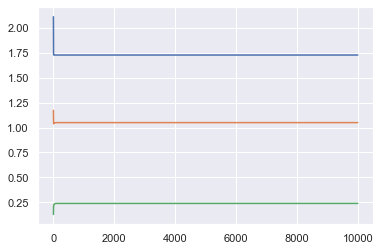

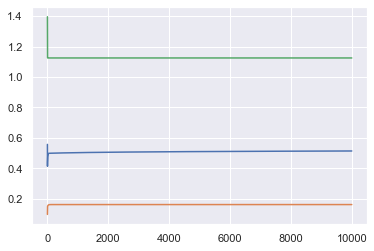

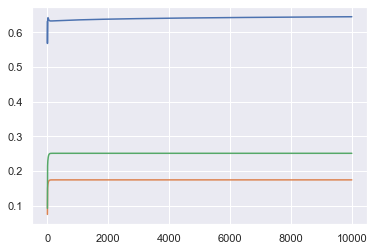

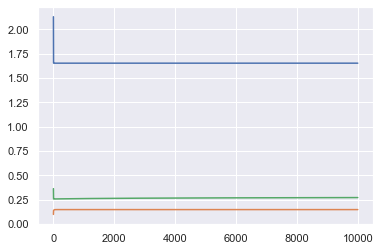

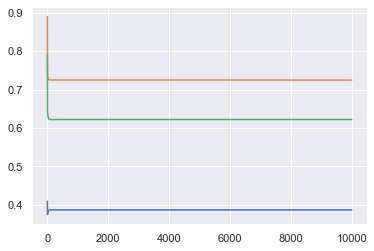

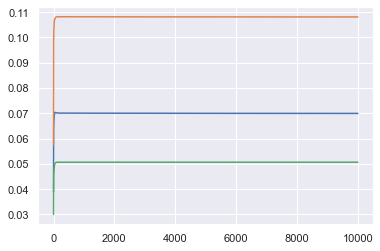

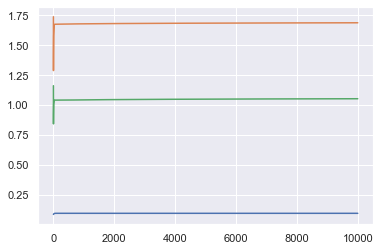

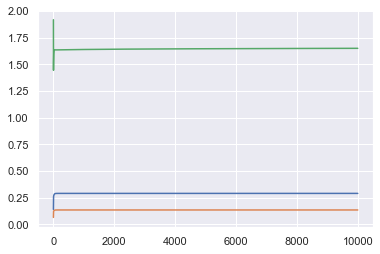

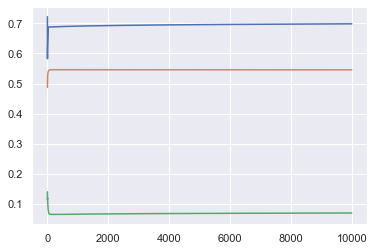

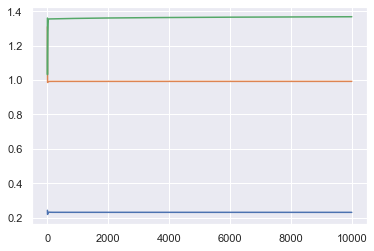

In [11]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_d[i])
    
    plt.show()

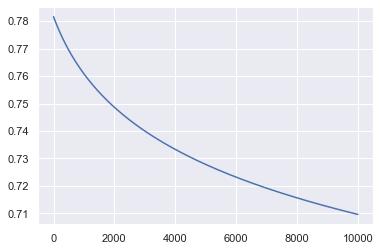

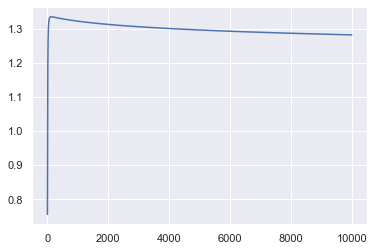

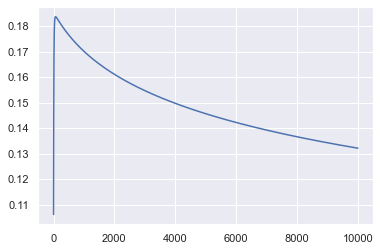

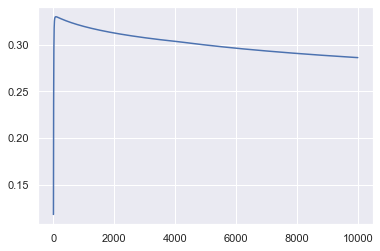

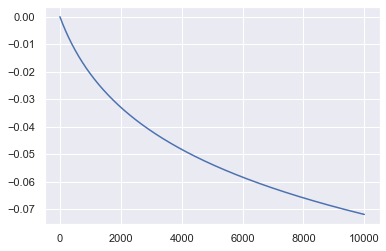

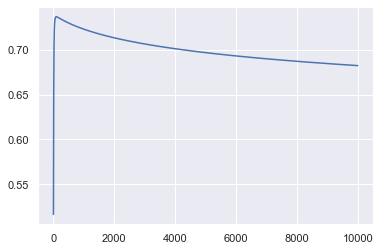

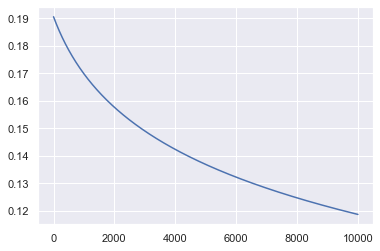

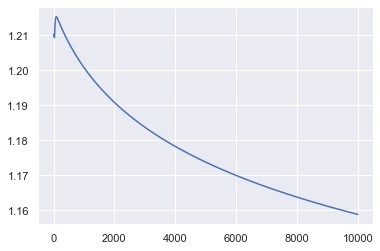

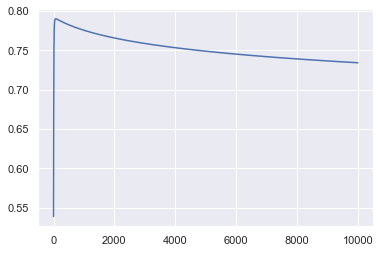

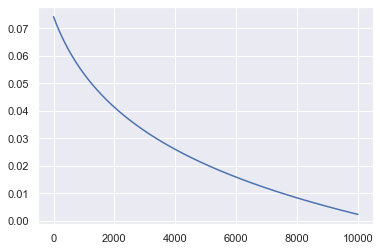

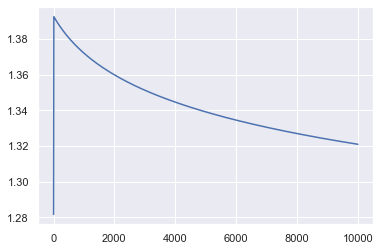

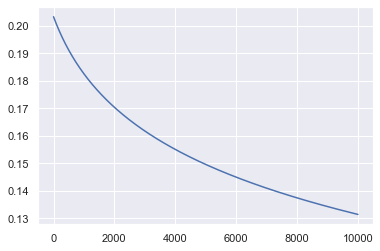

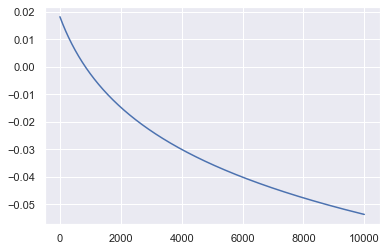

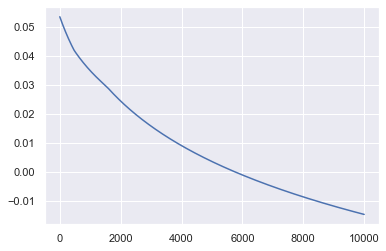

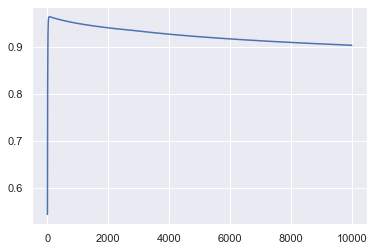

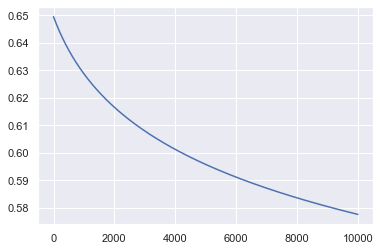

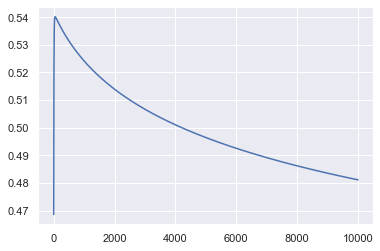

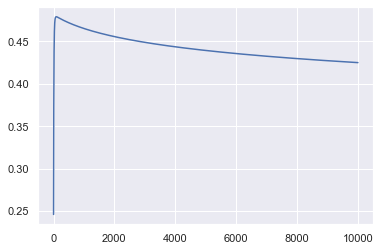

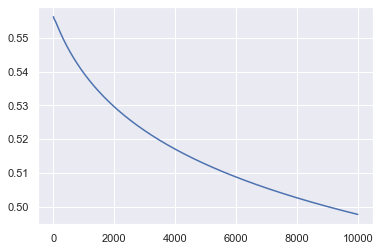

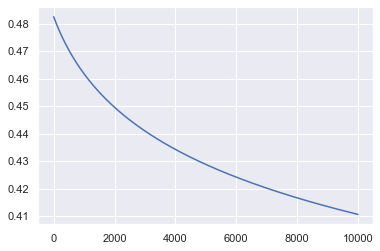

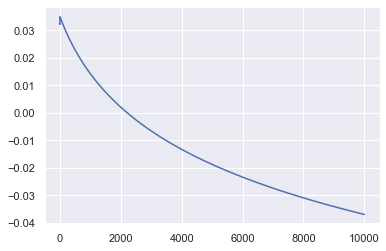

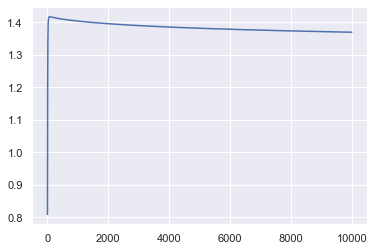

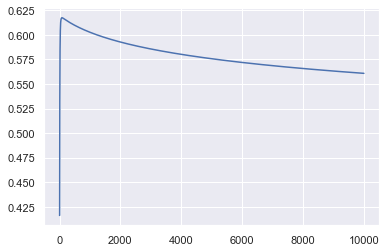

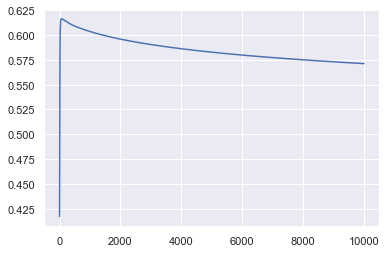

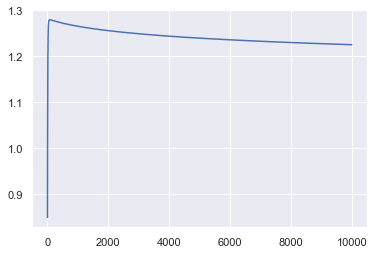

In [12]:
for agent in agents:
    plt.plot(agent.plot_eta)
    
    plt.show()

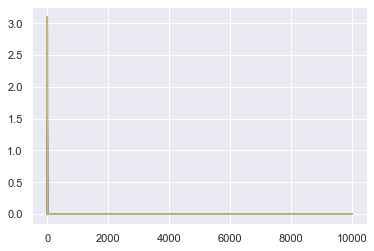

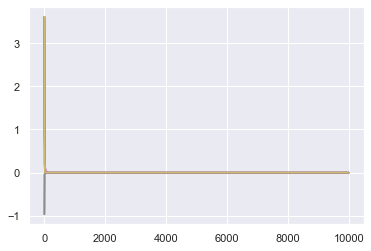

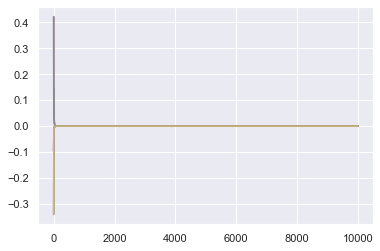

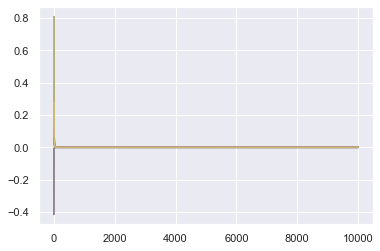

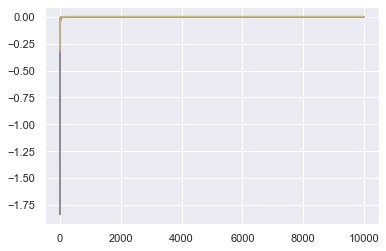

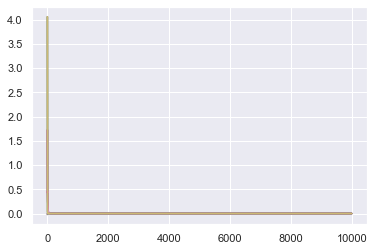

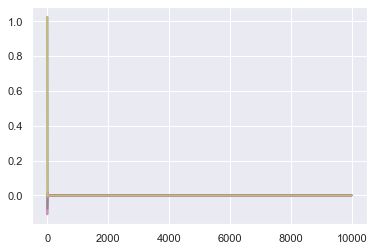

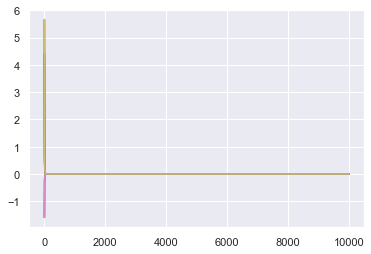

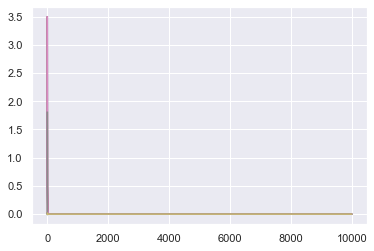

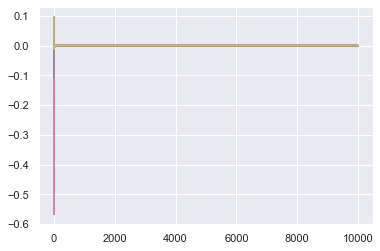

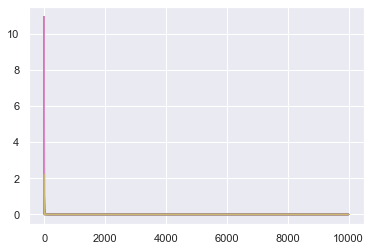

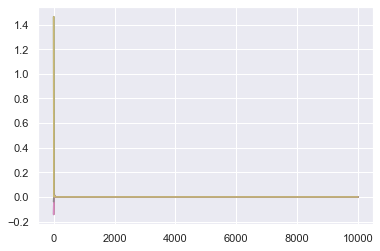

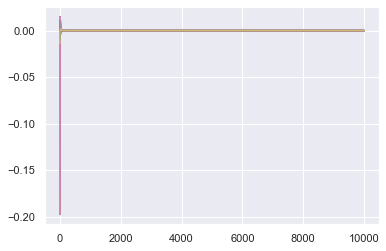

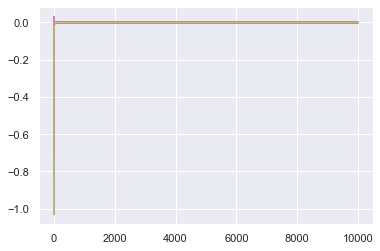

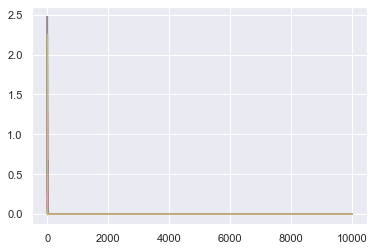

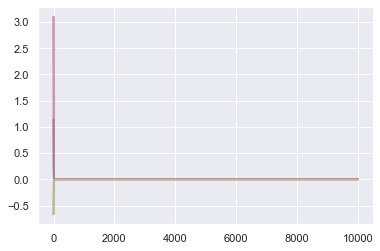

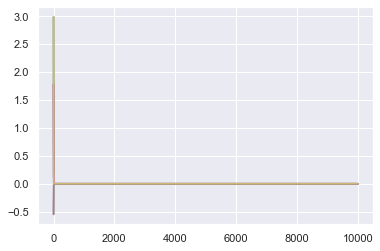

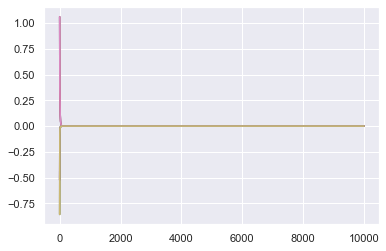

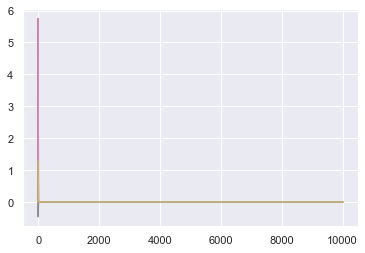

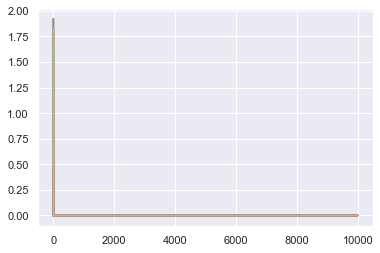

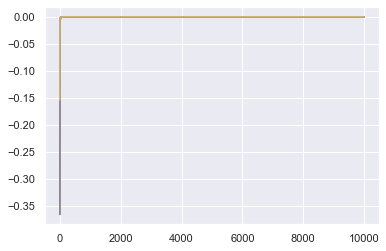

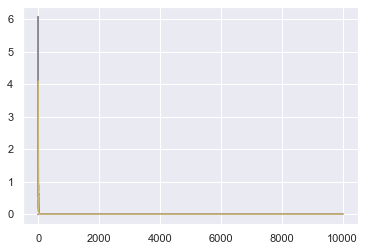

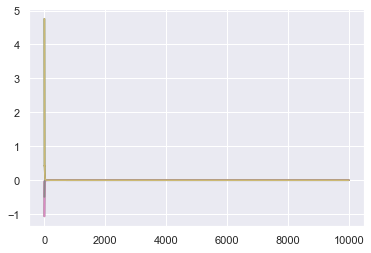

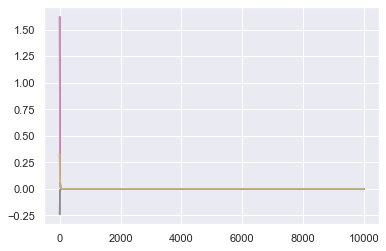

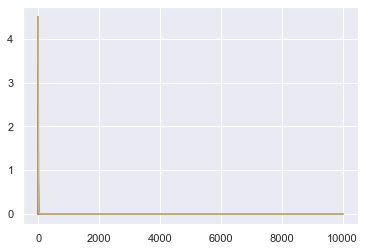

In [13]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(plot_balance[agent.id][i])
    
    plt.show()

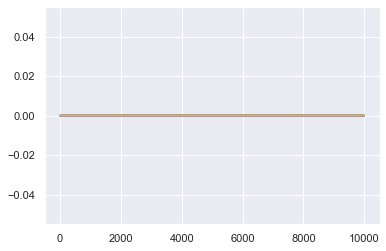

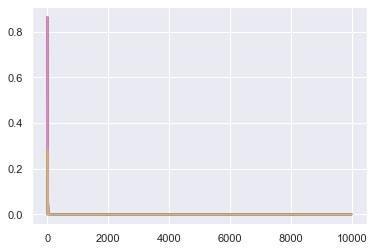

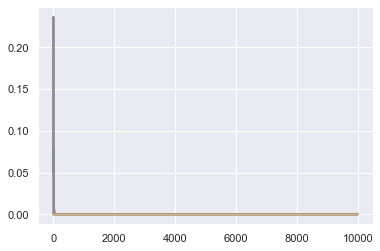

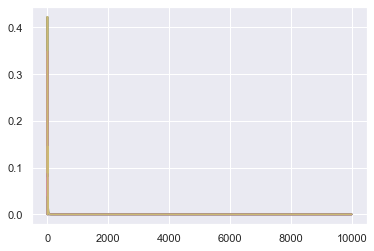

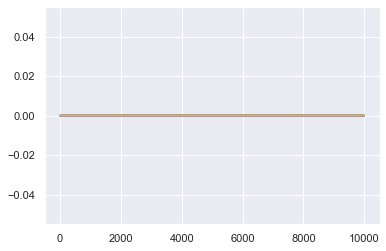

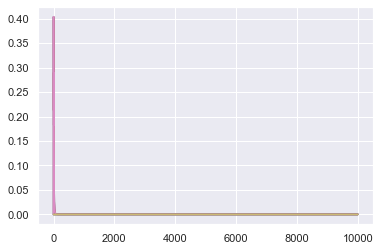

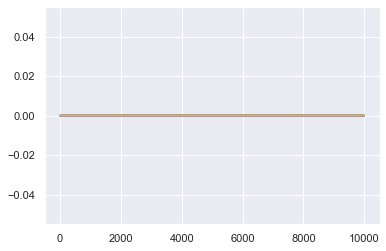

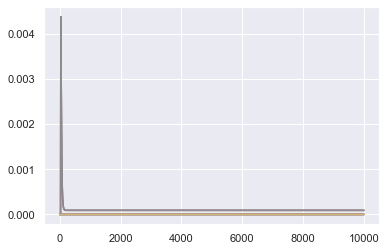

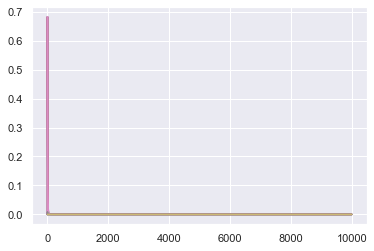

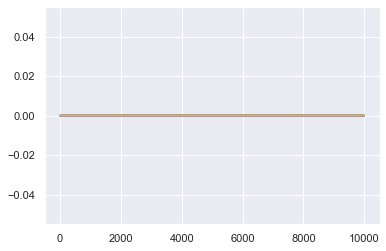

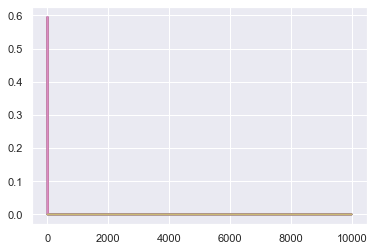

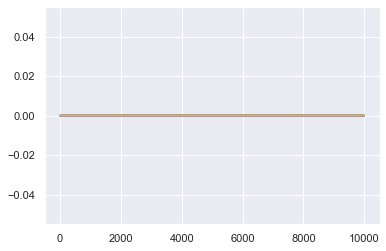

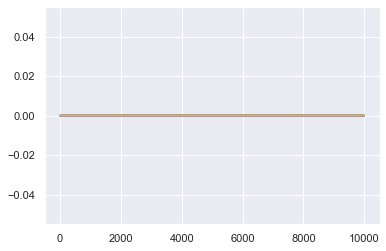

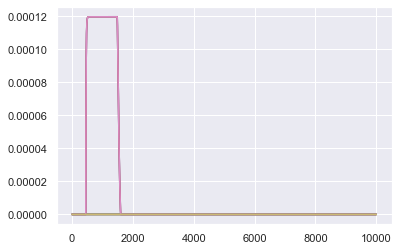

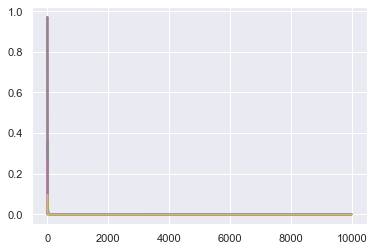

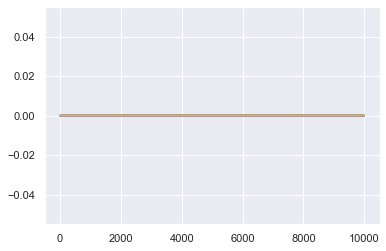

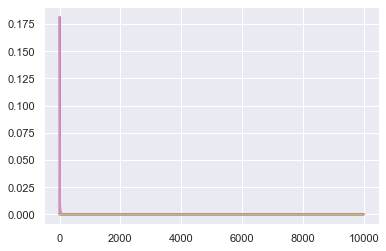

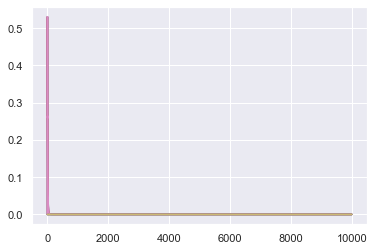

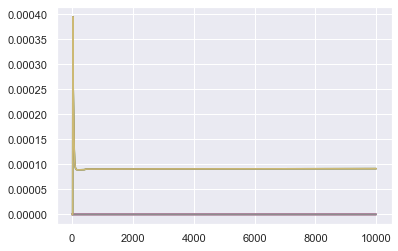

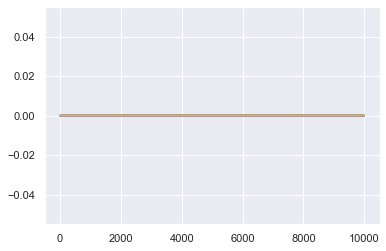

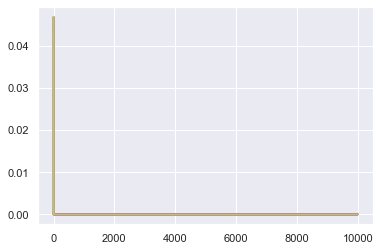

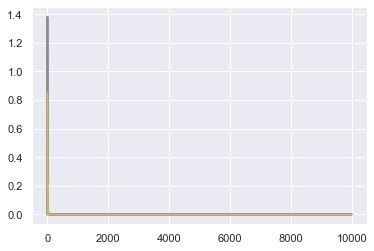

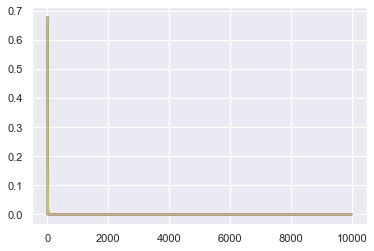

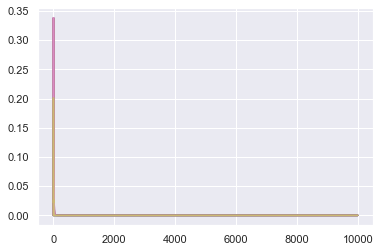

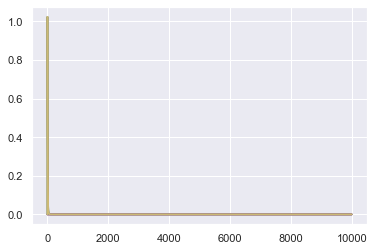

In [14]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(plot_penalty_residual[agent.id][i])
    
    plt.show()